In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


make sure to rename the columns by removing é


# Exploratory Data Analysis (EDA) for Packages and Receptacle Datasets

In [2]:
# Load datasets
packages_df = pd.read_csv('../data/raw/packages_data_2023_2025.csv',delimiter=';')
receptacle_df = pd.read_csv('../data/raw/receptacle_data_2023_2025.csv',delimiter=';')

In [3]:
# Rename for consistency
receptacle_df.rename(columns={
    'EVENT_TYPECD': 'EVENT_TYPE_CD',
    'nextetablissement_postal': 'next_etablissement_postal'
}, inplace=True)

In [4]:
packages_df.shape, receptacle_df.shape

((1000000, 6), (1000000, 5))

In [5]:
#convert dates to dateTime for compatibility
packages_df['date'] = pd.to_datetime(packages_df['date'])
receptacle_df['date'] = pd.to_datetime(receptacle_df['date'])

In [6]:
packages_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   MAILITM_FID                1000000 non-null  object        
 2   date                       1000000 non-null  datetime64[ns]
 3   etablissement_postal       973228 non-null   object        
 4   EVENT_TYPE_CD              1000000 non-null  int64         
 5   next_etablissement_postal  411733 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 45.8+ MB


In [7]:
receptacle_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RECPTCL_FID                1000000 non-null  object        
 1   date                       1000000 non-null  datetime64[ns]
 2   etablissement_postal       998889 non-null   object        
 3   EVENT_TYPE_CD              1000000 non-null  int64         
 4   next_etablissement_postal  576148 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 38.1+ MB


In [8]:
packages_df.head(n=5)

,RECPTCL_FID,MAILITM_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,USORDADZALGDAUN30050001900005,0000420016941,2023-07-04 05:00:00,NaN,12,ETAB_2389
1,USORDADZALGDAUN30050001900005,0000689914049,2023-07-04 05:00:00,NaN,12,ETAB_2389
2,USORDADZALGDAUN30050001900005,0000700051000,2023-07-04 05:00:00,NaN,12,ETAB_2389
3,USORDADZALGDAUN30102003900026,0031069949200,2023-12-04 05:00:00,NaN,12,ETAB_2389
4,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389


In [9]:
receptacle_df.head(n=5)

,RECPTCL_FID,date,etablissement_postal,EVENT_TYPE_CD,next_etablissement_postal
0,AEDXBADZAAEDACN45001001100219,2024-07-24 22:40:00.000,ETAB_0001,107,ETAB_0030
1,AEDXBADZAAEDACN45001001100219,2024-07-26 16:18:34.623,ETAB_0002,130,NaN
2,AEDXBADZAAEDACN45001001100219,2024-07-26 16:23:22.207,ETAB_0002,132,ETAB_0003
3,AEDXBADZAAEDACN45001001100219,2024-07-28 13:04:36.387,ETAB_0003,132,ETAB_0033
4,AEDXBADZAAEDACN45002001100075,2024-07-27 22:40:00.000,ETAB_0001,107,ETAB_0030


 Initial Observations
- both datasets cover the period from 2023 to 2025
- we have no target variable in either dataset
- for packages dataset:
    - 6 features in total with 5 categorical and 1 numerical
    - MAILITM_FID is unique identifier for each package
    - RECPTCL_FID is foreign key linking to receptacle dataset
    - etablissement_postal and next_etablissement_postal have some null values
- for receptacle dataset:
    - 5 features in total with 4 categorical and 1 numerical
    - RECPTCL_FID is unique identifier for each receptacle
    - EVENT_TYPE_CD has some null values

In [10]:
for column in packages_df.columns:
    print(f'{column} has {packages_df[column].nunique()} unique values.')
    print(f'{column} has {packages_df[column].isnull().sum()} null values.')
    print("\n")


RECPTCL_FID has 45306 unique values.
RECPTCL_FID has 0 null values.


MAILITM_FID has 212731 unique values.
MAILITM_FID has 0 null values.


date has 849213 unique values.
date has 0 null values.


etablissement_postal has 2825 unique values.
etablissement_postal has 26772 null values.


EVENT_TYPE_CD has 24 unique values.
EVENT_TYPE_CD has 0 null values.


next_etablissement_postal has 2716 unique values.
next_etablissement_postal has 588267 null values.




In [11]:
for column in receptacle_df.columns:
    print(f'{column} has {receptacle_df[column].nunique()} unique values.')
    print(f'{column} has {receptacle_df[column].isnull().sum()} null values.')
    print("\n")

RECPTCL_FID has 215867 unique values.
RECPTCL_FID has 0 null values.


date has 694907 unique values.
date has 0 null values.


etablissement_postal has 50 unique values.
etablissement_postal has 1111 null values.


EVENT_TYPE_CD has 17 unique values.
EVENT_TYPE_CD has 0 null values.


next_etablissement_postal has 9 unique values.
next_etablissement_postal has 423852 null values.




we notice the following:<br>
- receptacle dataset has more unique values for RECPTCL_FID than packages dataset, indicating one-to-many relationship<br>
- MAILITM_FID is unique in packages dataset.<br>
- packages dataset have more unique date values than receptacle dataset.<br>
- both datasets have null values in etablissement_postal and next_etablissement_postal columns. This requires processing later on<br>
- packages dataset has more unique values in the next_etablissement_postal column compared to receptacle dataset but also more null values. **further investigation is needed to understand why**<br>


In [12]:
packages_df.describe()

,date,EVENT_TYPE_CD
count,1000000,1000000.000000
mean,2024-04-09 07:24:35.733279488,27.271583
min,2020-02-01 09:22:30.150000,1.000000
25%,2023-08-30 09:47:12.600000,30.000000
50%,2024-04-30 07:12:00.241500160,32.000000
75%,2024-11-23 07:37:32.470500096,36.000000
max,2025-03-20 22:45:00,73.000000
std,NaN,12.326209


In [13]:
receptacle_df.describe()

,date,EVENT_TYPE_CD
count,1000000,1000000.000000
mean,2024-01-09 12:36:06.106905088,130.512065
min,2022-12-15 02:59:00,100.000000
25%,2023-05-31 09:15:37.029250048,107.000000
50%,2023-12-27 21:48:30,131.000000
75%,2024-08-05 11:27:24.005250048,132.000000
max,2025-03-21 15:15:00,178.000000
std,NaN,22.059407


for EVENT_TYPE_CD we notice different range of values for packages and receptacle datasets indicating different types of events.<br>

#### Visualizations
for now we will visualize the distribution of EVENT_TYPE_CD in both datasets.<br>



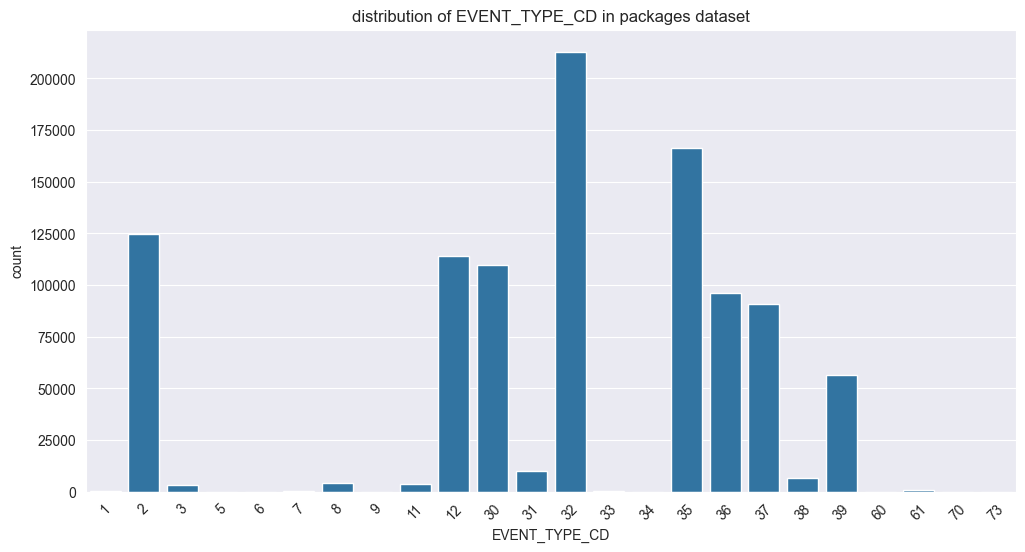

In [14]:
# Distribution of EVENT_TYPE_CD in packages dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=packages_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in packages dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

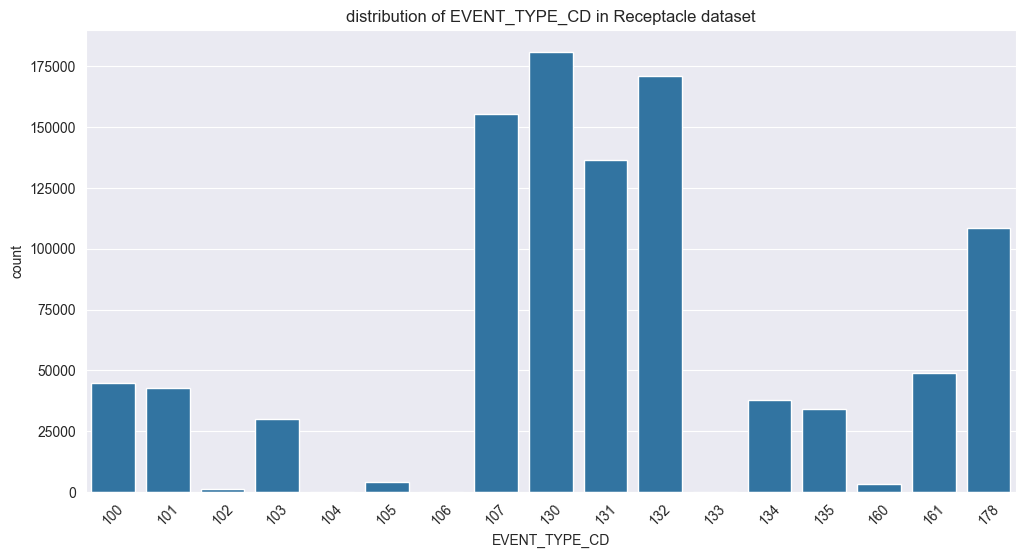

In [15]:
# Distribution of EVENT_TYPE_CD in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='EVENT_TYPE_CD')
plt.title('distribution of EVENT_TYPE_CD in Receptacle dataset')
plt.xlabel('EVENT_TYPE_CD')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

for etablissement_postal and next_etablissement_postal I will start with visualizing the receptacle dataset since the packages dataset has a lot of unique values<br>

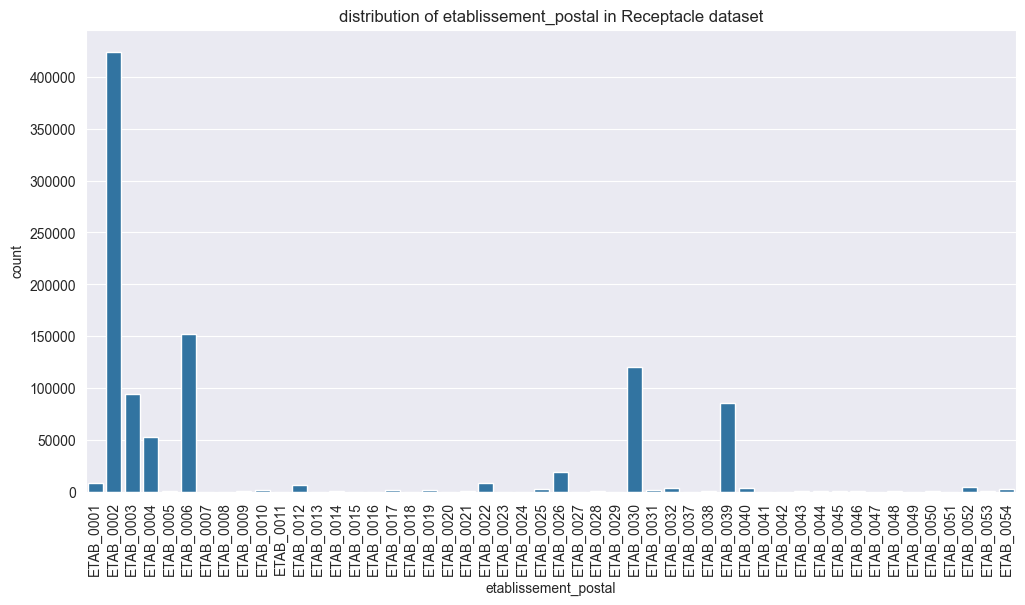

In [16]:
# Distribution of etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='etablissement_postal')
plt.title('distribution of etablissement_postal in Receptacle dataset')
plt.xlabel('etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()


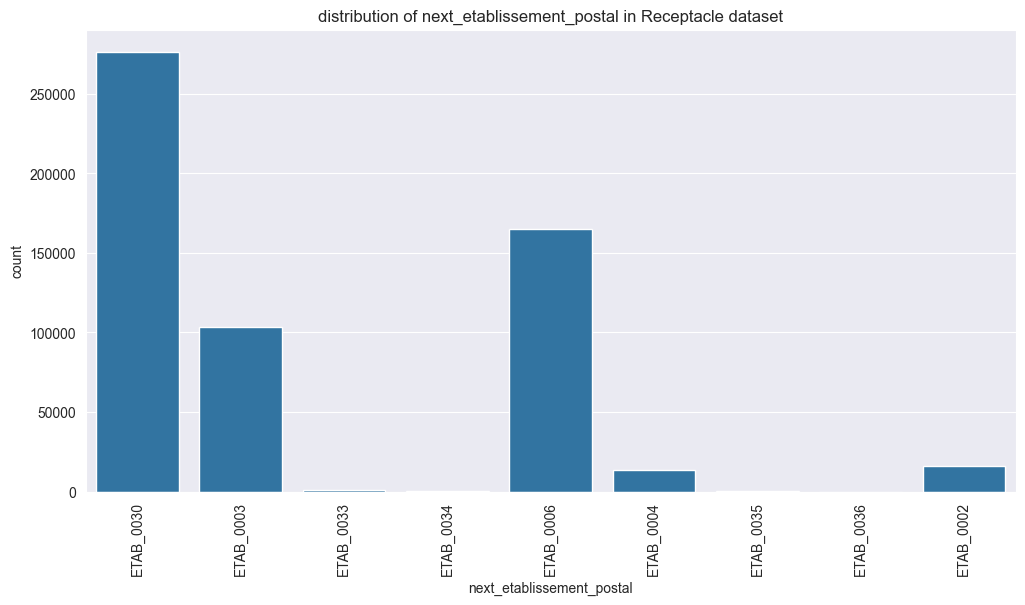

In [17]:
# Distribution of next_etablissement_postal in receptacle dataset
plt.figure(figsize=(12, 6))
sns.countplot(data=receptacle_df,x='next_etablissement_postal')
plt.title('distribution of next_etablissement_postal in Receptacle dataset')
plt.xlabel('next_etablissement_postal')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

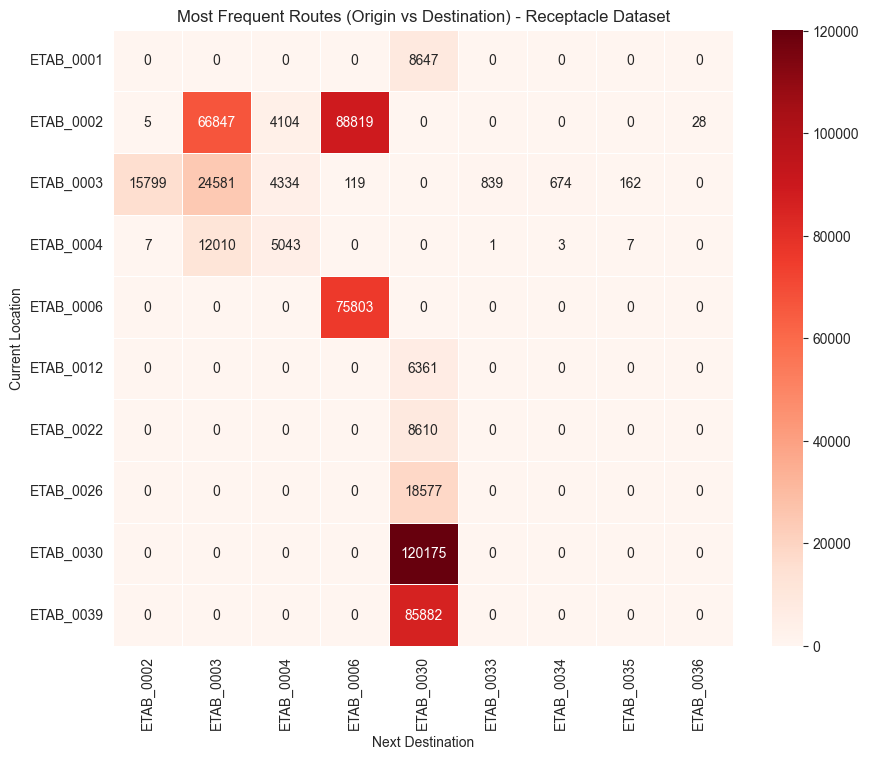

In [18]:
# 1.  Top 10 locations to keep the map small
top_locs = receptacle_df['etablissement_postal'].value_counts().head(10).index
top_next = receptacle_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = receptacle_df[
    (receptacle_df['etablissement_postal'].isin(top_locs)) &
    (receptacle_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Receptacle Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

we notice that some etablissements have significantly higher traffic compared to others, indicating  major distribution centers.<br>

for etablissement_postal and next_etablissement_postal we will create a heatmap to visualize the flow between current location and next destination.<br>
Count of parcels moving from A to B to see the density of connections between them

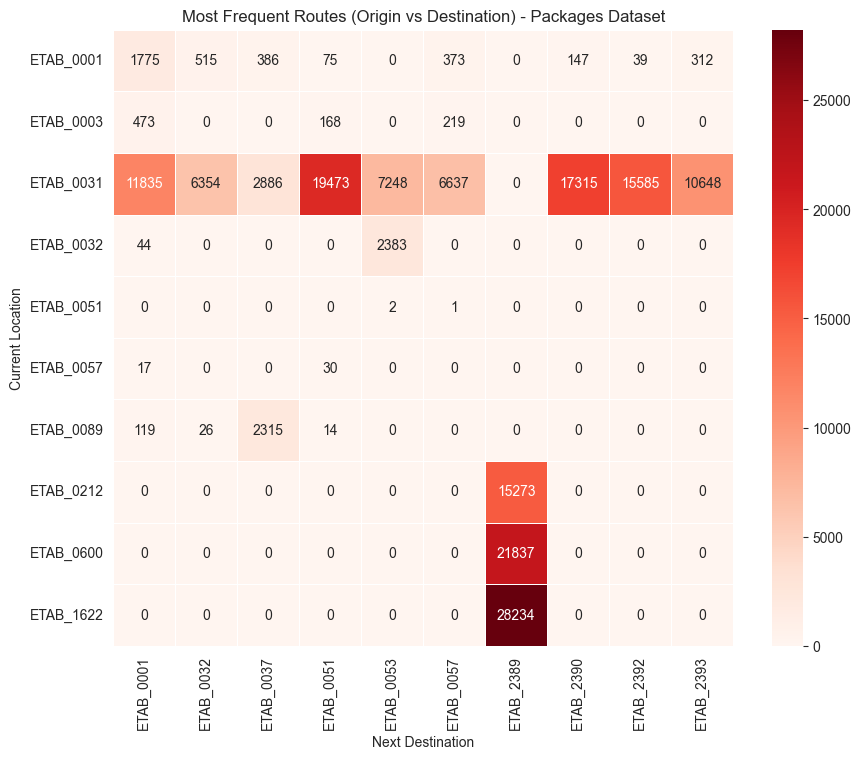

In [19]:
# 1.  Top 10 locations to keep the map small
top_locs = packages_df['etablissement_postal'].value_counts().head(10).index
top_next = packages_df['next_etablissement_postal'].value_counts().head(10).index

# 2. include only these top locations
filtered_df = packages_df[
    (packages_df['etablissement_postal'].isin(top_locs)) &
    (packages_df['next_etablissement_postal'].isin(top_next))
]

# 3. Create a Matrix (Cross-tabulation)
matrix = pd.crosstab(filtered_df['etablissement_postal'], filtered_df['next_etablissement_postal'])

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap='Reds', annot=True, fmt='d', linewidths=.5)
plt.title("Most Frequent Routes (Origin vs Destination) - Packages Dataset")
plt.xlabel("Next Destination")
plt.ylabel("Current Location")
plt.show()

C:\Users\LENOVO USER\AppData\Local\Temp\ipykernel_63396\2122875415.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Volume', y='Location', data=location_counts.head(20), palette='viridis')


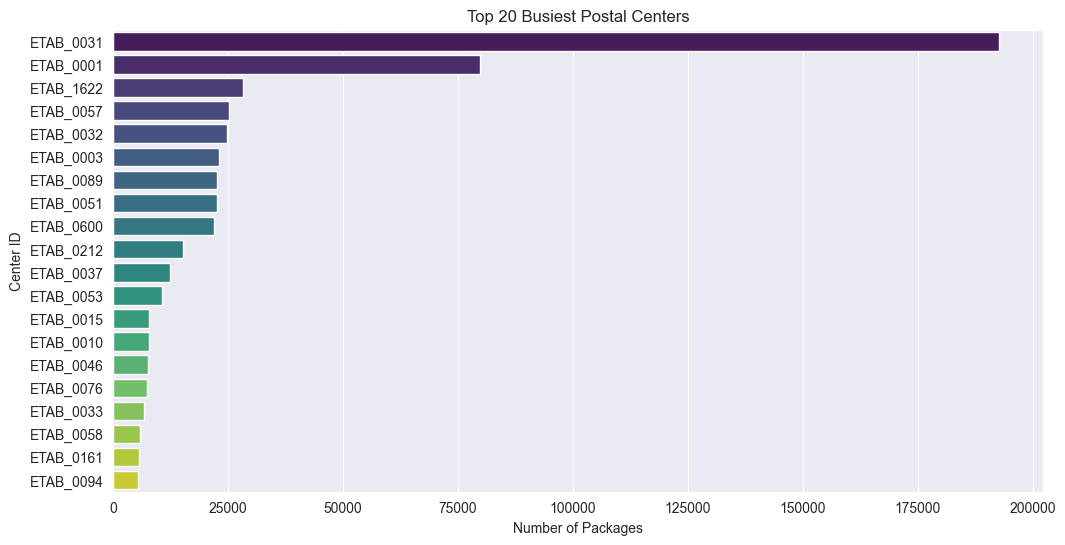

In [20]:
# Count packages per location
location_counts = packages_df['etablissement_postal'].value_counts().reset_index()
location_counts.columns = ['Location', 'Volume']

# keep only top 20 busiest centers
plt.figure(figsize=(12, 6))
sns.barplot(x='Volume', y='Location', data=location_counts.head(20), palette='viridis')
plt.title("Top 20 Busiest Postal Centers")
plt.xlabel("Number of Packages")
plt.ylabel("Center ID")
plt.show()

we notice the same pattern as before with some etablissements having significantly higher traffic compared to others.<br>

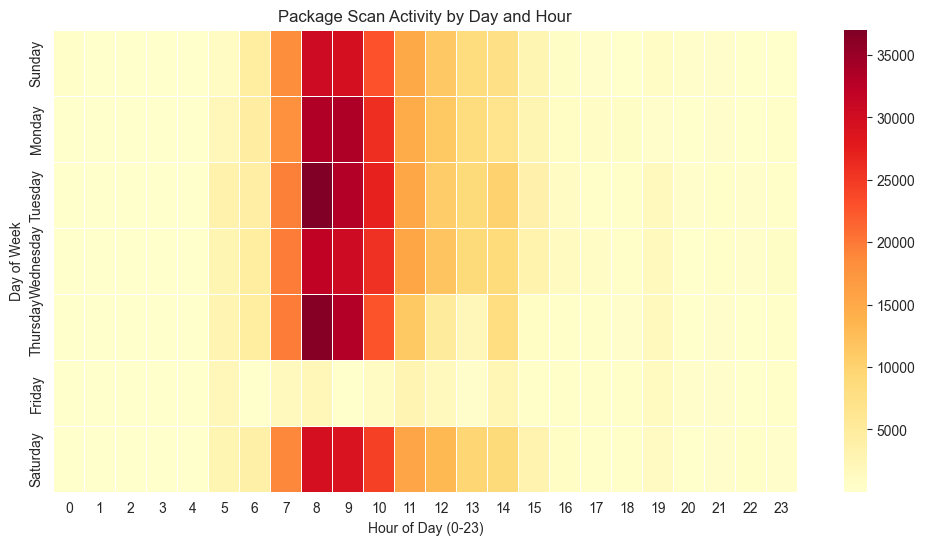

In [21]:

# 1. Extract Time Features
packages_df['hour'] = packages_df['date'].dt.hour
packages_df['day_of_week'] = packages_df['date'].dt.day_name()

# 2. Create a Pivot Table (Cross-tabulation)
# Rows = Day, Cols = Hour, Values = Count of Scans
heatmap_data = pd.crosstab(
    packages_df['day_of_week'],
    packages_df['hour']
)

days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
heatmap_data = heatmap_data.reindex(days_order)

# 3. Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=.5, annot=False)
plt.title("Package Scan Activity by Day and Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Day of Week")
plt.show()

we notice that the busiest times for package scans are during weekdays, particularly from mid-morning to late afternoon.<br>

In [22]:
# Merge datasets on RECPTCL_FID to analyze relationship
merged_df = pd.merge(
    packages_df,
    receptacle_df,
    on='RECPTCL_FID',
    how='left',
    suffixes=('_package', '_receptacle')
)

In [23]:
merged_df.head(n=20)

,RECPTCL_FID,MAILITM_FID,date_package,etablissement_postal_package,EVENT_TYPE_CD_package,next_etablissement_postal_package,hour,day_of_week,date_receptacle,etablissement_postal_receptacle,EVENT_TYPE_CD_receptacle,next_etablissement_postal_receptacle
0,USORDADZALGDAUN30050001900005,0000420016941,2023-07-04 05:00:00,NaN,12,ETAB_2389,5,Tuesday,NaT,NaN,NaN,NaN
1,USORDADZALGDAUN30050001900005,0000689914049,2023-07-04 05:00:00,NaN,12,ETAB_2389,5,Tuesday,NaT,NaN,NaN,NaN
2,USORDADZALGDAUN30050001900005,0000700051000,2023-07-04 05:00:00,NaN,12,ETAB_2389,5,Tuesday,NaT,NaN,NaN,NaN
3,USORDADZALGDAUN30102003900026,0031069949200,2023-12-04 05:00:00,NaN,12,ETAB_2389,5,Monday,NaT,NaN,NaN,NaN
4,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389,11,Thursday,2024-12-19 11:05:00.000,ETAB_0039,107.0,ETAB_0030
5,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389,11,Thursday,2024-12-21 13:00:29.973,ETAB_0002,130.0,NaN
6,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389,11,Thursday,2024-12-21 13:02:00.397,ETAB_0002,132.0,ETAB_0003
7,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389,11,Thursday,2024-12-22 07:48:30.920,ETAB_0003,132.0,ETAB_0004
8,FRCDGADZALGDAUN40553006010061,1A02349441537,2024-12-19 11:05:00,NaN,12,ETAB_2389,11,Thursday,2024-12-24 08:47:46.363,ETAB_0004,131.0,ETAB_0004
9,FRCDGADZALGDAUN32487005010095,1A09158628029,2023-12-01 07:45:00,NaN,12,ETAB_2389,7,Friday,2023-12-01 07:45:00.000,ETAB_0039,107.0,ETAB_0030


In [24]:
#number of packages per receptacle
packages_per_receptacle = packages_df.groupby('RECPTCL_FID')['MAILITM_FID'].nunique()
packages_per_receptacle.head()


RECPTCL_FID
AEDXBADZAAEDACN45001001100219    40
AEDXBADZAAEDACN45002001100075    18
AEDXBADZAAEDACN45003001100123    30
AEDXBADZAAEDACN45004001100073    10
AEDXBADZAAEDACN45005001100107    18
Name: MAILITM_FID, dtype: int64

In [25]:
# TODO: feature extraction for RECPTCL_FID in both datasets for further  analysis